# An HPC implementation of a revisited DE global optimization for LJ Cluster

**Molecular Modelling of Materials**

Prof. Guido Raos

A. Y. 2024/2025

Marco Lacagnina

HPC student

## Github Repository

Here is the link to the Github Repository where you can find the C++ code: https://github.com/marcolacagnina/hpc-cluster-optimizer

## Table of Contents

1. [Abstract](#Abstract)
2. [Introduction: Description of the problem](#Introduction:-Description-of-the-problem)
3. [Why is this problem so complex? (NP-Hard)](#Why-is-this-problem-so-complex?-(NP-Hard))
4. [Chosen Method: a variant of Differential Evolution (DE)](#Chosen-Method:-a-variant-of-Differential-Evolution-(DE))
5. [My Algorithm: an Implicit Basin-Hopping](#My-Algorithm:-an-Implicit-Basin-Hopping)
6. [HPC implementation: C++ and OpenMP](#HPC-implementation:-C++-and-OpenMP)
7. [General Setting and a Case Study (N = 22)](#General-Setting-and-a-Case-Study-(N-=-22))  
8. [HPC analysis](#HPC-analysis)
9. [Conclusion](#Conclusion)
10. [References](#References)

## Abstract

The aim of this work is to provide an **HPC implementation** of a global optimization algorithm for Lennard-Jones (LJ) clusters geometry. Specifically, the project was developed on **C++** by implementing a revised version of the Differential Evolution algorithm (DE), using the **OpenMP library** to implement **shared memory logic** suitable for the DE algorithm mechanism. \\

Thus following an HPC approach, the goal was to seek the **right trade-off between accuracy and computational efficiency of the algorithm**. In this regard, the DE algorithm itself as anticipated was revisited, specifically by implementing a revised version of its **jDE** variant and adding a crucial modification taking inspiration from the well-known Basin-Hoppings (BH) logic.

Finally, the goal was to make a **study of the computational performance of the algorithm**, analyzing its performance and also comparing it to Scipy implementation of BH and DE, in order to demonstrate the goodness and efficiency of this parallel implementation in C++.


## Introduction: Description of the problem

Consider a cluster with a number of N atoms, such atoms interact with each other by attracting or repelling each other and we can describe the nature of these interactions (forces) through a mathematical model. \\

Specifically, this work focuses on the **Lennard-Jones potential**, a simple but realistic model for describing forces between neutral atoms. As anticipated, the focus of this work was to perform **geometry optimization**, i.e., to find the configuration in space (thus the coordinates of each of the N atoms) that corresponds to the lowest energy configuration, so in this case with the lowest possible corresponding LJ potential energy. \\



## Why is this problem so complex? (NP-Hard)

From a computational point of view, **geometry optimization** is a particularly complex problem, since intuitively as the number of atoms N increases the number of possible configurations that the atoms can assume in space **explodes exponentially**, to be more precise as N increases the number of **isomers** grows exponentially.

Typically we are interested in the isomer with **global minimum energy** since it represents the most stable arrangement that the cluster can assume. \\

In this regard, the notion of Potential Energy Surface (**PES**) is used, which is a mathematical map that relates the geometry of a molecular system and the potential energy of the system, resulting in a multidimensional isosurface.

Consequently, the **goal** of geometry optimization is to actually find the bottom of the “**right valley**” that is the one that is actually deeper than the others whose lowest point corresponds to the global minimum of the entire PES we need to find. \\
However, in the case of LJ clusters, the PES is particularly complex for three main reason:
- It has an overall funnel-shaped structure, characterized by countless small valleys and barriers (saddles). This leads an optimization algorithm to be easily trapped, “fooled” by this tricky geometric shape.
- As N increases, the number of local minima (so the number of possible stable configurations that corresponds to the number of valleys) grows frighteningly fast.
- There are particular known combinations, such as N = 38, 75, 76, that are extremely complex, due to a corresponding PES with an unusual shape and even more difficult for a local optimizer to deal with. \\
For example, the LJ cluster with N = 38 is a famous example of a “double funnel” landscape, thus with two deep regions of competing stability. \\

For this reason, this problem is classified as **NP-Hard**, i.e., there is no algorithm that can solve the problem efficiently guaranteeing a solution for an arbitrary number of N atoms and typically its computation time grows exponentially.

## Chosen Method: a variant of Differential Evolution (DE)

### What is DE and how it works

It is a global optimization algorithm introduced in the paper **Differential Evolution - A Simple and Efficient Heuristic for Global Optimization over Continuous Spaces**, published in 1997 with authors Rainer Storn and Kenneth Price. \\

It is an optimization algorithm inspired by natural evolution, it is very **simple** and most importantly **lends itself very
well to parallel computation**. \\

- 1.**Initialization**: the algorithm creates a **population** of **NP** individuals, each individual representing a potential solution to the problem. In this work each individual corresponds to a cluster of atoms.

- 2.**Mutation**: for each individual in the population, a "**mutant**" version is created by **randomly** choosing three other individuals from population: A, B, C.
The mutant vector is calculated as follows: $mutant = C + F * (A-B)$ where F represents the **scaling factor**.
In our case, this operation consists of calculating this for each atom 3 times i.e. for all 3 coordinates of each atom.


In [ ]:
# MUTATION PROCESS

# "i" is the original chosen individual from the population, which will eventually be replaced

do { r1 = rng_local() % NP; } while (r1 == i);
do { r2 = rng_local() % NP; } while (r2 == i || r2 == r1);
do { r3 = rng_local() % NP; } while (r3 == i || r3 == r1 || r3 == r2);
for (int j = 0; j < N_atoms; ++j) {
    mutant[j].x = population_flat[r1 * N_atoms + j].x + F_current * (population_flat[r2 * N_atoms + j].x - population_flat[r3 * N_atoms + j].x);
    mutant[j].y = population_flat[r1 * N_atoms + j].y + F_current * (population_flat[r2 * N_atoms + j].y - population_flat[r3 * N_atoms + j].y);
    mutant[j].z = population_flat[r1 * N_atoms + j].z + F_current * (population_flat[r2 * N_atoms + j].z - population_flat[r3 * N_atoms + j].z);
 }

**Key Aspect**: in this way, the algorithm can explore the space of the "solutions" in a smart way, using the differences between existing solutions to guide the search for new ones.

- 3.**Crossover**: A "**trial**" individual is created by combining the characteristics of the mutant individual with those of the original individual. It is decided component by component (atom by atom then) whether to take the atom of the mutant individual or the original individual, through a random mechanism determined by a **CR** parameter, the so-called “crossover rate,” which determines the probability of choosing the atom of the mutant cluster or not.

In [ ]:
# CROSSOVER PROCESS

# "j_rand" is used just to implement a security clause, to make sure that the new ‘trial’ solution is not an identical copy of the original one

int j_rand = rng_local() % N_atoms;

for (int j = 0; j < N_atoms; ++j) {
     trial[j] = (dist_real(rng_local) < CR || j == j_rand) ? mutant[j] : population_flat[i * N_atoms + j];
}

- 4.**Selection** The trial individual is compared to the original individual. If the trial one offers a **better solution**, i.e., it possesses lower energy than the original one, then replaces it within the population; otherwise, the original individual survives.

In [ ]:
double trial_energy = energyFunc(trial);

if (trial_energy < energies[i]) {
    std::copy(trial.begin(), trial.end(), next_population_flat.begin() + i * N_atoms);
    next_energies[i] = trial_energy;
    F_vals[i] = F_current;
} else {
    std::copy(population_flat.begin() + i * N_atoms, population_flat.begin() + (i + 1) * N_atoms, next_population_flat.begin() + i * N_atoms);
    next_energies[i] = energies[i];
}

- 5.**The mechanism is repeated for generations**: This process is repeated for many generations, the population then evolves gradually and naturally over the generations selecting more and more clusters **strong** (i.e. with lower energy), naturally converging to the optimal solution to the problem.

### My variant of DE: jDE-like with Reset mechanism inspired by BH

Initially, I implemented the classic version of the DE just described, however, I quickly noticed the weakness of this very powerful algorithm: **the extreme dependence on hyper-parameters**. In particular, it was extremely difficult for me to find the right balance as N increases, specifically to find the right combination of the 4 parameters [NP, generations, F, CR]: \\
**NP** (the number of individuals in the population), **generations**, **F** (scaling factor) and **CR** (crossover rate).

Therefore, I made two changes, such that the starting DE algorithm was improved, making it more **robust**, **effective** and **efficient**.

- 1. **jDE-STYLE**: I was inspired by the well-known variant of DE, the **jDE**, presented in the paper **Self-Adapting Control Parameters in Differential Evolution: A Comparative Study on Numerical Benchmark Problems** by Brest in 2006. \\
An adaptive logic is introduced, whereby each individual "i" has its own: \\
$ F_i ∈ [F_{min} ,F_{max}] $ and $CR_i ∈ [0,1]$ . \\
Originally, in this algorithm at each generation and for each individual "i", with a certain probability $ τ_1 $ and $τ_2$, the updating of parameters $F_i$ and $CR_i$, respectively, occurs. Then, if a **mutant individual** has to replace an original individual, it inherits the parameters $F_i$ and $CR_i$. \\
I originally implemented this logic, however, I realized that **it was too aggressive** for this problem and that I would have to find the right compromise between variability and stability of the algorithm.

**Instead, I adopted this logic**:

In [ ]:
std::uniform_real_distribution<double> dist_real(0.0, 1.0);
std::uniform_real_distribution<double> dist_F_range(0.3, 1.0);
#pragma omp for
for (int i = 0; i < NP; ++i) {
    # ... INTERNAL LOGIC OF DE ...
    double F_current = F_vals[i];
    if (dist_real(rng_local) < 0.1) { F_current = dist_F_range(rng_local); }
    # ...    the rest of the DE logic
    const double CR = CR_fixed;       # CR_fixed Equals to 0.9
}

**Key Difference**: \\
**FIXED CR**: Its value is fixed a priori, specifically 0.9, for each individual and in each generation. This value seems reasonable given the nature of the problem, in fact what happens is that such a high, fixed value allows the trial individual to represent a strong perturbation from the original individual, attempting to **promote escape from the countless local minima that characterize the PES of LJ clusters**. \\



On the other hand, the **F** parameter is implemented as in a standard jDE logic, in particular a random F is drawn between $F_{min}$ and $F_{max}$. \\
I chose $F_{min} = 0.3$ and $F_{max} = 1.0$ and it seems like a good compromise since with small Fs we get weak mutation that we might see as trying to go down a valley in a gentle way, while with large Fs we get strong and sometimes **voluntarily destructive** mutation with the goal of getting out of the local PES minima. \\
The update of the $F_i$ parameter for each individual is performed with a certain probability $\tau = 0.1$, this value is low since the intention is to try to pass on to the new stronger individual an F parameter that was actually successful in the previous generation. \\
So basically **90% of the time the values F that lead to success are maintained**.

- 2. **Reset mechanism inspired by BH algorithm**: as mentioned above, the biggest problem to address is being able to escape from the countless local minima that characterize the PES under consideration. The famous BH algorithm does this through a Monte Carlo mechanism that allows it to “jump between local minima.” I instead took inspiration from this mechanism, introducing a "reset" logic that is triggered when the search ends in a dead end; in summary when the algorithm realizes it has reached a dead end, it takes the 25% (or 20%) of the weakest population (that is, those with the higher energy) and resets them by initializing them randomly.

## My Algorithm: an Implicit Basin-Hopping

For this specific problem of minimizing LJ Clusters, the reference algorithm is represented by the well-known Basin-Hopping (BH) method, introduced by Wales and Doyce in 1977. \\
Essentially, the method "transforms" the complex PES into a simplified view, like a sort of "staircase" where the steps are the local minima, so what happens in practice is a direct jump from one local minimum to another. In particular, the process is carried out through a two-phase iterative cycle: \\
**1) Perturbation ("the Jump")**: starting from a configuration that is in a local minimum, the coordinates of all atoms are significantly and randomly modified, in such a way as to expel the system from its current "basin of attraction" and land it in a completely different region of the PES. \\
**2) Local Optimization and Acceptance (the "Descent")**: once "landed" in the new valley, a **local optimizer** is initiated to reach the lowest point, that is, the step of that staircase. The characteristic of this mechanism is that acceptance occurs through the **Metropolis criterion**, whereby: \\
if the new configuration is stronger (lower energy), it replaces the old one; if it is not, it might still do so despite being a "worse" configuration with a certain probability.

This mechanism allows BH to escape from "energy traps" in order to have the possibility of finding the region where the true global minimum is hidden, even if to do so it must temporarily "accept" being in a less deep valley.

The key requirements that makes this method so **effective** are also its greatest implementation constraints:
- 1. **Gradient request**: local optimization critically relies on the a**vailability of the analytical gradient of the energy function**.
- 2. **Serial approach**: This mechanic, although extremely effective and indeed the best one for being able to deal with the PES of LJ clusters, is **intrinsically serial** because it assumes dealing with one “solution at a time” and improving it. It clearly remains possible to run multiple instances of the algorithm in parallel, however, it would not result in “efficient” parallelism.

Instead, I wanted to follow a **gradient-free** approach, so based on Differential Evolution, with the aim of implementing a **purely evolutionary strategy** equipped with mechanisms to escape stagnation just like BH, in line with the HPC goal of achieving competitive results in global exploration with a simpler and more general implementation. \\
Also, the choice of a DE-style algorithm allowed me to better implement a **natural parallel implementation** which would have been less suitable in the case of the BH algorithm.

### Escape stagnation like BH with Reset Mechanism "Brutal Jump": the **key** of my solver

Here there is the implementation of the mechanism "**Brutal Jump**":

In [ ]:
# === UPDATE OF STALL_COUNTER ===

double current_best_energy = *std::min_element(energies.begin(), energies.end());
if (std::abs(current_best_energy - best_energy) < tolerance) {      # tolerance set to 1e-6
    stall_counter++;      # Stagnation detected, increment stall_counter
} else {
    stall_counter = 0;    # Improvement in the current generation, reset counter and update best_energy
    best_energy = current_best_energy;
}

Classic approach used in an iterative algorithm to implement an **Early Stopping** logic, which is a mechanism to stop optimization when the algorithm is "stagnating," thus leading to a waste of resources and time. It is necessary to implement a "counter" **stall_counter** to monitor how long stagnation has been occurring. \\

The **stall_counter** is therefore used in two consecutive phases of the algorithm:
- 1) To implement the Early Stopping mechanism.
- 2) To implement my "**Brutal jump**" logic.


In [ ]:
# ====== 1) EARLY STOPPING MECHANISM =====
if (stall_counter >= early_stopping_stall) {
    if (gen < generations - 1) {
        std::cout << "Early stopping at generation " << gen
                << " due to stagnation. Best energy: " << best_energy << std::endl;
      }
      break;
}

In [ ]:
# 2) === RESET MECHANISM / BRUTAL JUMP ===
if (stall_counter > 0 && stall_counter % reinitialization_stall_trigger == 0) {           # Trigger: Stagnation Detection
    std::cout << "  -> Generation " << gen << ": Stagnation detected. Re-initializing  "
        << reinitialization_fraction * 100 << "% of the population." << std::endl;

    const int num_to_reinitialize = static_cast<int>(NP * reinitialization_fraction);
    std::vector<int> indices(NP);
    std::iota(indices.begin(), indices.end(), 0);
    std::stable_sort(indices.begin(), indices.end(),
              [&](int a, int b) { return energies[a] < energies[b]; });

#pragma omp parallel for
    # Re-initialize the worst clusters, THE "BRUTAL JUMP"
    for (int i = 0; i < num_to_reinitialize; ++i) {
        int worst_idx = indices[NP - 1 - i];
        auto& rng_local = rngs[omp_get_thread_num()];
        Cluster cl(N_atoms, D, energyFunc, rng_local);

        const auto& new_atoms = cl.getAtoms();
        std::copy(new_atoms.begin(), new_atoms.end(), population_flat.begin() + worst_idx * N_atoms);
        energies[worst_idx] = cl.getEnergy();
      }
     best_energy = *std::min_element(energies.begin(), energies.end());
  }

**1) EARLY STOPPING MECHANISM**: calculate the current best energy in the population (the lowest, therefore); if the difference between the new energy and that of the previous generation is very small (relative to the "**tolerance**" parameter), then this counter is incremented; if there has been an improvement, then the **counter is reset** and the value of the new best **best_energy** is updated.

**2) BRUTAL JUMP**: **At the start** we can see the **TRIGGER condition**, so that it activates if the algorithm is indeed in a stall phase (**stall_counter** $> 0$) and the number of consecutive stall generations has reached an exact multiple of the reinitialization_stall_trigger parameter. \\
This is done because in this way it prevents the mechanism from activating too frequently, allowing the algorithm to break out of stagnation with the normal evolutionary flow of the algorithm and choosing to intervene only if such a blockage persists.

Essentially, the worst portion of the population is identified and this fraction is determined by the parameter **reinitialization_fraction**. \\
After being efficiently identified, through a parallel loop this population is **entirely replaced with completely new individuals**, ready to enter the "evolution mechanism" in the next generation. \\


**This powerful mechanism just described and implemented is the KEY to my algorithm**. Essentially, it serves to simulate the effect of the selection phase in the BH algorithm, with the difference that this occurs in a much simpler, more efficient manner and without the use of any local optimizer (and thus also without the gradient of the objective function, the LJ potential energy in our case). \\
**In summary the comparison between BH and my algorithm**:

| Feature | BASIN-HOPPING (BH) | My jDE-like |
|:---|:---|:---|
| **Escape Strategy** | Random Perturbation + **Local Optimization** | Stagnation + **Population Reset/"Brutal jump"** |
| **Required Input** | Energy Function + **Gradient** | **Energy Function Only** |
| **Process Nature**| Hybrid (Stochastic + Deterministic) | Purely Stochastic / Evolutionary |

## HPC implementation: C++ and OpenMP

I chose **C++** to carry out this work in line with the general idea of HPC, which we can summarize as **performance (parallel computation minimizing as possible the overhead)** and **numerical accuracy as high as possible**. In particular, it allowed me to implement parallel computation using the **OpenMP** framework, a parallelism model based on **shared memory** and therefore the most suitable model for the logic of population-based evolutionary algorithms, as in this case.

**OpenMP** is "de-facto" a standard API for writing parallel applications with **shared memory**, utilizing specific compilation directives that allow for control over the flow of parallel execution. \\
Here I want to show the specific optimization using the **OpenMP framework**:

### Compute LJ potential with SIMD strategy

Consider that the Lennard-Jones potential between two atoms is calculated in the following way:

\begin{equation*}
U_{LJ} = 4\epsilon \left[ \left(\frac{\sigma}{R_{ij}}\right)^{12} - \left(\frac{\sigma}{R_{ij}}\right)^{6}\right]
\end{equation*}


So the total energy of the cluster is calculated in the following way:
 \begin{equation*}
U_{LJ}(\mathbf{R}_0,...,\mathbf{R}_{N-1}) = \sum_{i=0}^{N-2} \sum_{j=i+1}^{N-1} 4\epsilon \left[ \left(\frac{\sigma}{R_{ij}}\right)^{12} - \left(\frac{\sigma}{R_{ij}}\right)^{6}\right]
\end{equation*}

In [ ]:
inline double computeLJEnergy_SIMD(const std::vector<Point3D>& atoms) {
        const double epsilon = 1.0;     # reduced units
        const double sigma = 1.0;       # reduced units
        double energy = 0.0;
        const std::size_t N = atoms.size();

        # The constant sigma^2 is calculated only once outside of loops, for efficiency purpose
        const double sigma2 = sigma * sigma;

        # The outer loop iterates over each atom i
        # The pairwise interactions between each pair of atoms i < j
        # avoiding duplicates and self-interaction.
        for (std::size_t i = 0; i < N; ++i) {

#pragma omp simd reduction(+:energy)
            for (std::size_t j = i + 1; j < N; ++j) {
                const double dx = atoms[i].x - atoms[j].x;
                const double dy = atoms[i].y - atoms[j].y;
                const double dz = atoms[i].z - atoms[j].z;

                # Compute r^2 in an efficient way avoiding slow operation std::sqrt <-> (sqrt())
                const double r2 = dx * dx + dy * dy + dz * dz;

                # Avoid std::pow
                const double inv_r2 = 1.0 / r2;
                const double s2_div_r2 = sigma2 * inv_r2;
                const double r6 = s2_div_r2 * s2_div_r2 * s2_div_r2;      #(sigma^2/r^2)^3
                const double r12 = r6 * r6;

                energy += 4.0 * epsilon * (r12 - r6);
            }
        }

        return energy;
    }

The calculation of the LJ energy is a potential **bottleneck** on the algorithm, so its implementation in a smart and efficient way is **crucial**, otherwise the algorithm might suffer too much. \\
Here i want to explain the **key aspect** of this efficient implementation:

- 1. **Avoid std::pow() and std::sqrt()**: These functions are very general, much slower than a product or simple division between variables, and therefore difficult to be optimized by the compiler. For this reason, where necessary and if possible, I have always implemented powers with explicit multiplication. \\
Therefore, I calculated by hand: $\sigma^2$ outside the loop (to avoid unnecessary redundant calculation), $R^2$ for each pair of atoms considered, the inverse of $R^2$ through explicit division.

**I also want to highlight how I efficiently calculated the "complex" computation within the LJ energy expression**. Essentially, the two critical "objects" were calculated manually as follows:
\begin{equation*}
(\sigma/ R)^6 = (\sigma^2 / R^2 ) ^3 = (\sigma^2 / R^2 ) * (\sigma^2 / R^2 )* (\sigma^2 / R^2 ) =  r_6
\end{equation*}
\begin{equation*}
(\sigma/ R)^{12} = r_6 ^ 2 = r_{12}
\end{equation*}

**Note**: modern CPU prefer simple arithmetic operations that lend themselves well to SIMD vectorization.



- 2. **SIMD directive with Reduction Pattern**: **SIMD** stands for "**Single Instruction, Multiple Data**" which is a **data-level parallelism** paradigm so that a single instruction performs the same operation on multiple data in parallel. There are no **explicit threads**, everything is managed via CPU registers, and the compiler receives a hint through directives to vectorize the loop in question using **hardware vector units of the CPU**. \\
For example, if we had an instruction of this type:

In [ ]:
c[0] = a[0] + b[0];
c[1] = a[1] + b[1];
c[2] = a[2] + b[2];
c[3] = a[3] + b[3];

Then the SIMD mechanism would use a single instruction to perform such an operation in a single iteration. This is an example of a "toy" instruction just to explain the mechanism.  What happens is that the compiler, through the specific **#pragma omp simd** directive, receives the **hint** to invoke the real SIMD instruction that performs this operation.

In [ ]:
SIMD_ADD: c[0..3] = a[0..3] + b[0..3];

In our function, what happens is that the single thread involved **does not** execute the iteration j=i+1 up to N-1 ONE BY ONE, but executes 4, or 8, or 16 AT A TIME, depending on the CPU being used and therefore its specific SIMD instruction.

Additionally, it is necessary to specify the **parallel reduction** using the "**reduction(+:energy)**" directive. \\
Each SIMD unit of the CPU adds a contribution to the *energy* variable, which is SHARED by the other SIMD units within the CPU, thus risking a **race condition**. For this reason, the specified clause tells the compiler that each SIMD unit MUST work on its own local copy of *energy*, so that in the end, all results can be **safely summed**.

**Note**: clearly, the computational benefit of this operation is actually appreciable when the number N of atoms starts to be considerable, and therefore it is advantageous to vectorize such instruction.

### Make us of OpenMP for Parallel Shared-Memory model

In general, **Fork-Join** is the parallel execution model of the **OpenMP framework**. This mechanism can be summarized by the following scheme:

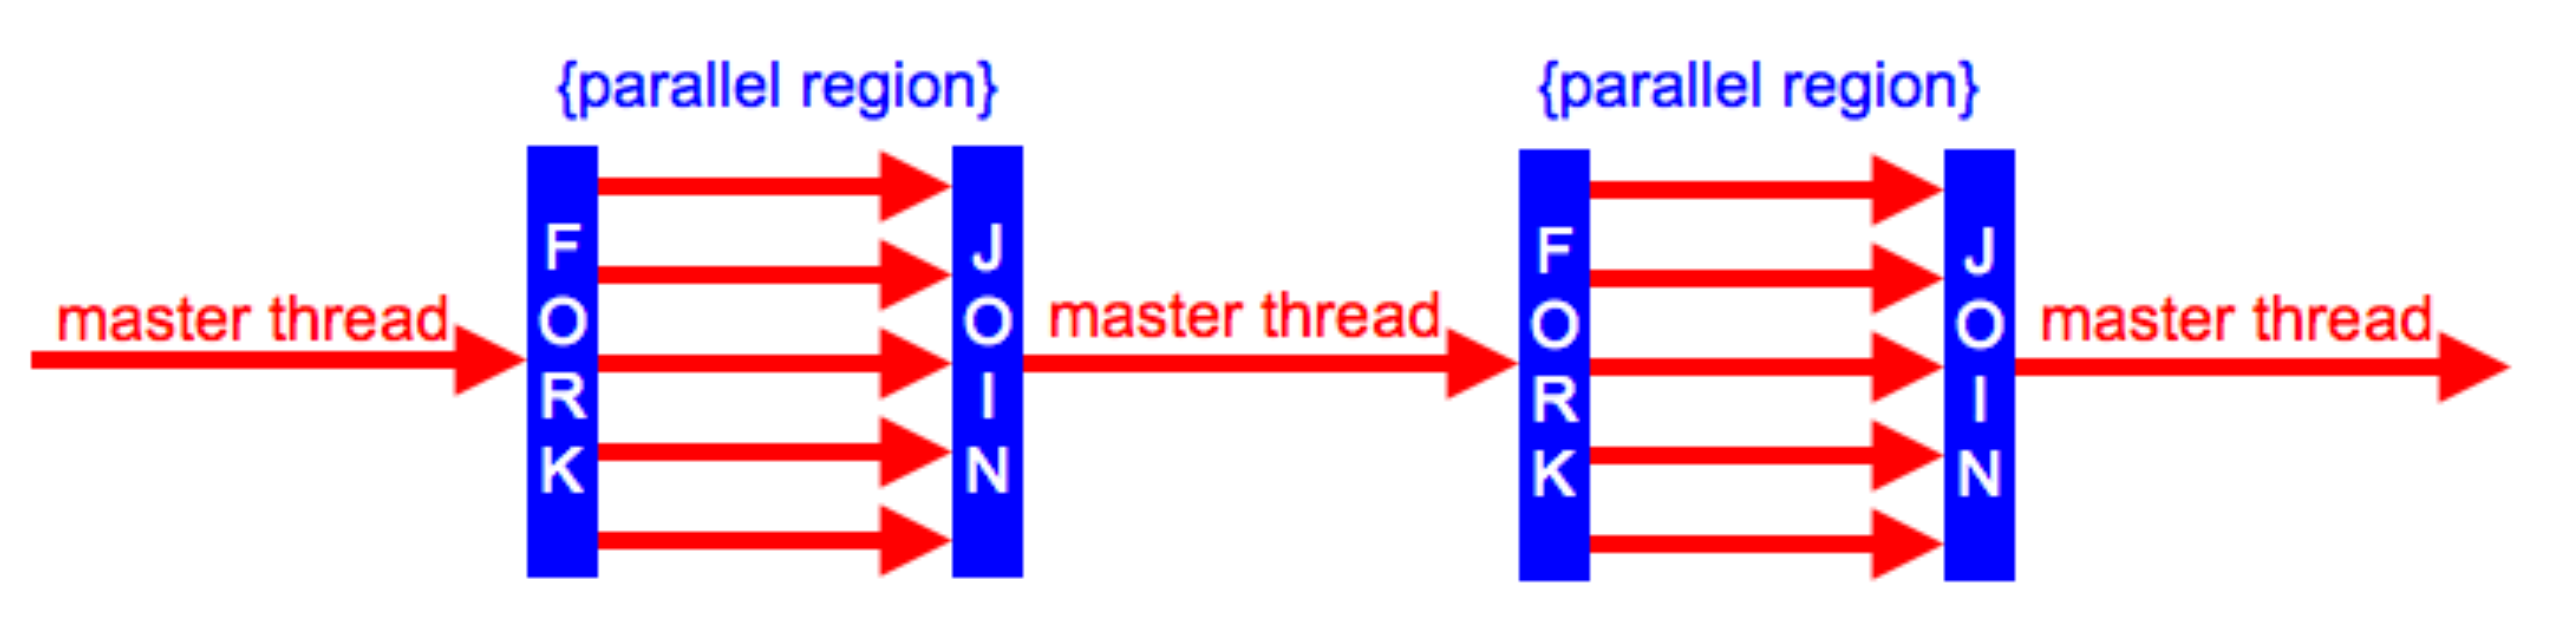

The program starts with a serial execution carried forward by a thread, the so called **master thread**. \\
Then, in general, the code is made up of "**parallel regions**" in which the Master thread creates a group of threads composed of itself and other threads, the so-called **Fork** operation. What happens is that all the threads work in parallel, following the "**SPMD**" (**Single Program Multiple Data**) model, so the part of the code executed by each thread is THE SAME, however, all the threads work with different data and each operates on the same shared global memory of the node. \\
At the end of each parallel region, a **Join** occurs, meaning that all the threads created during the **fork** phase cease to exist and only the **master thread** continues the serial execution of the code, until a new parallel phase is encountered, and so on until the end.

Additionally, the start of a parallel region is marked by the **OpenMP** directive "**#pragma omp parallel**"

Basically, **the execution is made parallel when necessary**, specifically in the following phases of the algorithm:

- 1. **Optimized Parallel Initialization**: The initial population, composed of NP individuals, is created. The creation cycle is optimized by dividing the iterations of the cycle in parallel among the various threads.

In [ ]:
# === 1) Optimized Parallel Initialization ===

#pragma omp parallel          <---- OpenMP directive to create the Parallel Region
    {
        # Each thread gets its own pre-initialized generator
        auto& rng_local = rngs[omp_get_thread_num()];
        std::uniform_real_distribution<double> dist_F_range_init(0.3, 1.0);

#pragma omp for             <----- OpenMP directive to optimize the parallelization inside a For loop.
        for (int i = 0; i < NP; ++i) {
            Cluster cl(N_atoms, D, energyFunc, rng_local);

            const auto& atoms = cl.getAtoms();
            std::copy(atoms.begin(), atoms.end(), population_flat.begin() + i * N_atoms);
            energies[i] = cl.getEnergy();
            F_vals[i] = dist_F_range_init(rng_local);
        }
    }

- 2. **Parallelization inside each generation of the DE**: The DE cycle (discussed previously) is encapsulated within a Parallel Region, allowing for the parallel execution of the individual generation. Each thread has its own private variables, necessary for its OWN execution of the DE cycle iteration assigned to it during execution by the scheduler. In [Memory management](#memory-management) I will delve into the role of these local variables and their significance.

In [ ]:
# === 2) Parallelization inside each generation of the DE  ===

#pragma omp parallel
        {
            # Using local generator already pre-allocated
            int thread_id = omp_get_thread_num();
            auto& rng_local = rngs[thread_id];
            auto& mutant = mutant_buffer[thread_id];
            auto& trial = trial_buffer[thread_id];
            std::uniform_real_distribution<double> dist_real(0.0, 1.0);
            std::uniform_real_distribution<double> dist_F_range(0.3, 1.0);
#pragma omp for
            for (int i = 0; i < NP; ++i) {
                # === INTERNAL LOGIC OF DE ALREADY DISCUSSED ===
            }
        }

- 3. **Brutal Jump**: already discussed, this mechanism is used so that the 20/25% initialization of the population is done in parallel in order to speed-up the process

In [ ]:
# ===== 3) Brutal jump ======

#pragma omp parallel for        <--- Another OpenMP Directive to create a Parallel Region, including directly a for loop.
            for (int i = 0; i < num_to_reinitialize; ++i) {
                # INTERNAL LOGIC OF THE "BRUTAL JUMP" ALREADY DISCUSSED
            }

### Memory management

In the HPC context, the "speed" of a program is not determined only by the number of operations per second, but also by the **speed at which data can be read and written**. **Inefficient memory management can create bottlenecks that negate the benefits of parallelization**. For this reason, **three key memory management strategies** have been implemented.

- 1.**Flat Data Structures for Cache Locality**: To represent the population, a strategic choice was made to use a single "flattened" vector: **population_flat(NP*N_atoms)**. This choice ensures that all data of the atoms in the entire population are stored in a **contiguous block of memory**. This allows for the exploitation of **Cache Locality**, meaning it encourages the CPU to load the data of "nearby" atoms along with the "target" atom into the cache, drastically reducing latency by avoiding constant and slow accesses to the main RAM. Furthermore, **contiguous data** encourages the CPU to make greater use of SIMD units, even if the latter are not explicitly invoked through the already discussed directive #pragma omp simd.

In [ ]:
std::vector<Point3D> population_flat(NP * N_atoms);
std::vector<Point3D> next_population_flat(NP * N_atoms);

- 2. **Pre-allocation of Work Buffers for Threads**: Within the main cycle of generations, new solutions (*mutants* and *trials*) are continuously created and modified. Dynamically creating **std::vector** for these solutions at each iteration would be **disastrous for performance**. \\
The solution, therefore, was to **pre-allocate** local work buffers, one for each OpenMP thread. \\
This way, **dynamic memory allocations** within the DE cycles are eliminated, which could create overhead and also introduce **CONTENTION BETWEEN THREADS**. \\
Instead in this way, the threads continuously reuse the same **pre-allocated memory blocks**.

In [ ]:
std::vector<std::vector<Point3D>> mutant_buffer(max_threads, std::vector<Point3D>(N_atoms));
std::vector<std::vector<Point3D>> trial_buffer(max_threads, std::vector<Point3D>(N_atoms));

To be more precise, two "external containers" **mutual_buffer** and **trial_buffer** are created, each containing <max_threads> "drawers", with each drawer corresponding to a thread and using its two buffers (allocated memory blocks) to work on the creation of mutants and trials throughout the execution of the algorithm; essentially, each thread has its own **privately allocated workspace that is allocated only once**.

So each thread takes its own "drawers" (buffers) within the parallel region, in order to avoid **race conditions** and **dynamic allocations**, in the following way:






In [ ]:
int thread_id = omp_get_thread_num();     # <-- OpenMP instruction that returns the private id that identifies the single thread
                                          # within the parallel region

auto& mutant = mutant_buffer[thread_id];
auto& trial = trial_buffer[thread_id];

- 3. **Copy-free updates with std::swap**

The algorithm works with two global objects (visible to each thread) that represent the **population** of the evolutionary algorithm: \\
**1) population_flat** which represents the current population within the single generation, is the global object seen by each thread and used to create mutants and trials.

In [ ]:
# === Creation of the "mutant" cluster ===

for (int j = 0; j < N_atoms; ++j) {
    mutant[j].x = population_flat[r1 * N_atoms + j].x + F_current * (population_flat[r2 * N_atoms + j].x - population_flat[r3 * N_atoms + j].x);
    mutant[j].y = population_flat[r1 * N_atoms + j].y + F_current * (population_flat[r2 * N_atoms + j].y - population_flat[r3 * N_atoms + j].y);
    mutant[j].z = population_flat[r1 * N_atoms + j].z + F_current * (population_flat[r2 * N_atoms + j].z - population_flat[r3 * N_atoms + j].z);
}

# === Creation of the "trial" cluster ===
int j_rand = rng_local() % N_atoms;
for (int j = 0; j < N_atoms; ++j) {
    trial[j] = (dist_real(rng_local) < CR || j == j_rand) ? mutant[j] : population_flat[i * N_atoms + j];
}

**2) next_population_flat**: represents the population that will be used in the next generation, in particular it contains (**selection mechanism** of the DE already discussed) the cluster **trial[i]** if the latter has lower energy than the parent "i", otherwise it contains the parent "i".

In [ ]:
 double trial_energy = energyFunc(trial);
if (trial_energy < energies[i]) {
       std::copy(trial.begin(), trial.end(), next_population_flat.begin() + i * N_atoms);
       next_energies[i] = trial_energy;
       F_vals[i] = F_current;     # <----- Adaptive mechanism, the algorithm "learns" the best F for that trial in that "position"
} else {
    std::copy(population_flat.begin() + i * N_atoms, population_flat.begin() + (i + 1) * N_atoms, next_population_flat.begin() + i * N_atoms);
    next_energies[i] = energies[i];
}

In the end, the following operation **std::swap** is performed, at zero cost O(1), which consists of swapping the pointers of the two objects.

In [ ]:
population_flat.swap(next_population_flat);

This is a FUNDAMENTAL operation for the computational efficiency of the algorithm. In this way, it avoids copying the billions of values contained within each population, but performs a cost-free operation so that data is overwritten in the same block of memory without the need to unnecessarily allocate space at each generation of the DE. \\

In summary, I use **1) population_flat** as the representation of the current population, the **current truth**, necessary for the construction of mutants and trials; this data is STABLE throughout the generation, making the algorithm **embarrassingly parallel**, \\
while **2) next_population_flat** is used within the single generation as the **workspace for the future**, acting as a "**scratchpad**."

## General Setting and a Case Study (N = 22)

In this section, I want to explain the **experimental setup of the simulations**, the hyper-parameters used and a case study (N = 22).

### Cluster Initialization and its importance

In [ ]:
void Cluster::generateRandomBoxCluster(int N, double D, std::mt19937& rng) {
    double noise_scale = 0.1;
    atoms.clear();
    atoms.reserve(N);

    int Nx = std::ceil(std::cbrt(N));
    int Ny = Nx;
    int Nz = Nx;

    std::normal_distribution<double> dist(0.0, noise_scale * D);

    int count = 0;
    for (int i = 0; i < Nx && count < N; ++i) {
        for (int j = 0; j < Ny && count < N; ++j) {
            for (int k = 0; k < Nz && count < N; ++k) {

                double x = i * D + dist(rng);
                double y = j * D + dist(rng);
                double z = k * D + dist(rng);
                atoms.emplace_back(x, y, z);
                ++count;
            }
        }
    }
}

The initialization of each individual/cluster in the population is NOT a purely random placement of atoms in space, but I use a technique known as “**perturbed grid**”. \\
Specifically, atoms are initially placed at the vertices of a simple cubic lattice with step D fixed to 1.2. Next, a small random shift, sampled from a Gaussian distribution, is added to each coordinate of each atom to break the perfect symmetry of the lattice. This approach ensures that the initial population explores configurations that are neither too ordered nor too chaotic, providing a good starting point for optimization. \\
The mechanism ensures that a grid sufficient to contain N atoms is created; in fact, if we had N = 30 atoms, a 3x3x3 grid made up of 27 spots would not be enough, at least a 4x4x4 grid (64 spots) is necessary.


Example of an **initial cluster (N=30)** generated using the perturbed grid method. \\
Note the **quasi-ordered structure** that serves as a starting point for the population of the Differential Evolution algorithm.

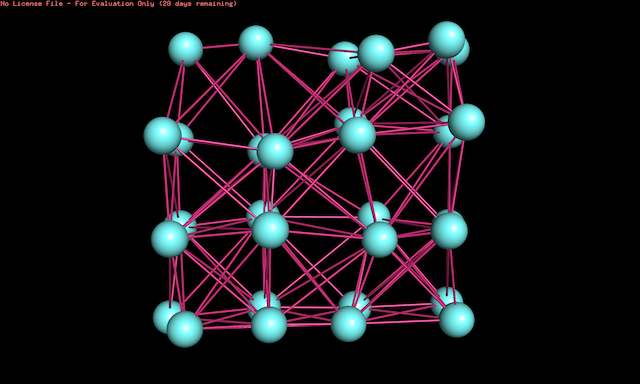

Note: I used [PyMOL](https://www.pymol.org/) software for visualization.

**Important Note on the parameter D** \\
For **small clusters** ($N <= 20$) it seemed more advantageous to use $D = 1.6$, while for **larger clusters** ($N > 20$) I used $D = 1.2$. \
We can then conclude this:
- 1. **Small clusters, LARGER D**: it is more convenient to give the algorithm more space to explore.
- 2. **Big clusters, SMALLER D**: starting with larger configurations seems inconvenient, it would force the solver to waste generations **just to compact the structure**, before the real geometric optimization can even begin. With D = 1.2 we start from a “**more promising**” region of space.

This mechanism highlights **the importance of smart initialization** for effectiveness in optimization.

### **Hyper-Parameters**

As I mentioned earlier, in general, Differential Evolution is an algorithm with strong **sensitivity** to its hyper-parameters. \\
My variations have significantly reduced this sensitivity; however, it is **impossible** to reduce it to zero. I therefore list the parameters used.

| Hyperparameter | Value Used | Explanation |
|:---|:---|:---|
| **`NP` (Population Size)** | 160 (for N ≤ 20), 250 (for N > 20) | Controls the search diversity. Increased for larger problems to ensure adequate exploration of the vast solution space. |
| **`generations`** | 20000 (maximum value) | Upper limit for the run. The algorithm almost always terminates earlier due to an **early stopping** mechanism that detects stagnation. |
| **`CR` (Crossover Rate)** | 0.9 (fixed) | Crossover probability. A high value (near 1.0) promotes **exploration** by preserving the integrity of new solutions generated by mutation. |
| **`F` (Scaling Factor)** | Adaptive, initialized in [0.3, 1.0] | Mutation factor. It is adapted dynamically (jDE-style): the algorithm "learns" and reuses `F` values that lead to success. |
| **`reinitialization_stall_trigger`**| 150 (for N ≤ 20), 100 (for N > 20) | Number of stalled generations to trigger a reset. Lowered for larger problems to make the algorithm **more reactive** in escaping local minima. |
| **`reinitialization_fraction`** | 0.25 (for N ≤ 20), 0.20 (for N > 20) | Fraction of the population to reset. Lowered for larger problems to make the "brutal jump" **less disruptive**, preserving more information. |
| **`D`** | 1.6 (for N ≤ 20), 1.2 (for N > 20) | Step D on the inizialization. For smaller clusters, it is more advantageous to provide more “room to maneuver”; for large clusters a more compact initial configuration is more appropriate|

**Comment on the tuning of [reinitialization_stall_trigger, reinitialization_fraction] parameters**: \\
**For larger size problems (N > 20)**, the potential energy landscape (PES) seems to appear significantly more rugged. \\
This greatly increases the risk of **premature convergence**. To counter this phenomenon, two synergistic modifications were made to the parameters governing my reinitialization mechanism "**Brutal Jump**":
- 1. **Increased Reactivity**, i.e., **reinitialization_stall_trigger** reduced from 150 to 100. By lowering the stall generation threshold, the algorithm becomes more "impatient." It is forced to abandon regions of the search space where it is not making improvements more quickly, thus promoting broader global exploration and avoiding wasting computational time in sub-optimal attraction basins.
- 2. **Reduction of Destructiveness** , i.e., **reinitialization_fraction** reduced from 0.25 to 0.20: At the same time, the intensity of the reset "**Brutal Jump**" is decreased. Instead of performing a drastic reset, a more controlled disturbance is chosen. This approach injects a sufficient dose of diversity to escape stagnation while preserving 80% of the population, thereby maintaining the valuable "evolutionary memory" and the structural information accumulated up to that point.

In summary, the strategy tends to evolve from "**rare but drastic resets**" for smaller problems to "**more frequent but relatively gentler resets**". This method has proven to be more effective in navigating very complex energy landscapes, balancing the need to explore new regions with the importance of not discarding good partial solutions already discovered.

### Obtained Result: A Case Study on N = 22 (0.0% error)

To demonstrate the solver's effectiveness, I want to present a case study on a non-trivial problem: **N=22 atoms**, which corresponds to the cluster with the **largest N for which my solver achieved 0.0% error**. \\
The solver was executed 10 times, the **best result** was selected. \\

**INITIAL CONFIGURATION**

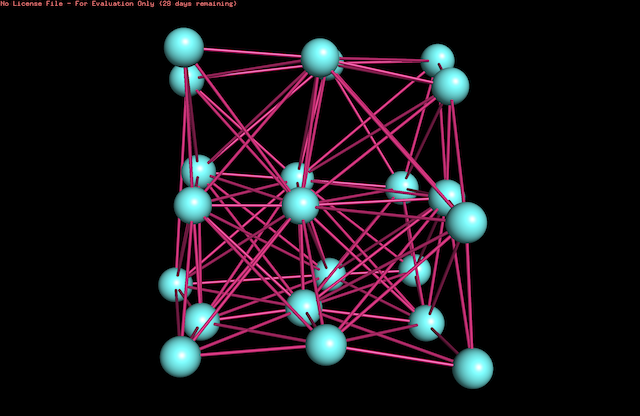

**FINAL STRUCTURE (Symmetry View)**

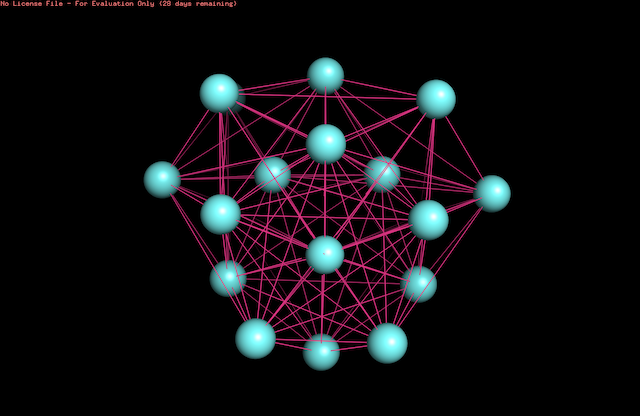

**FINAL STRUCTURE (3D view)**

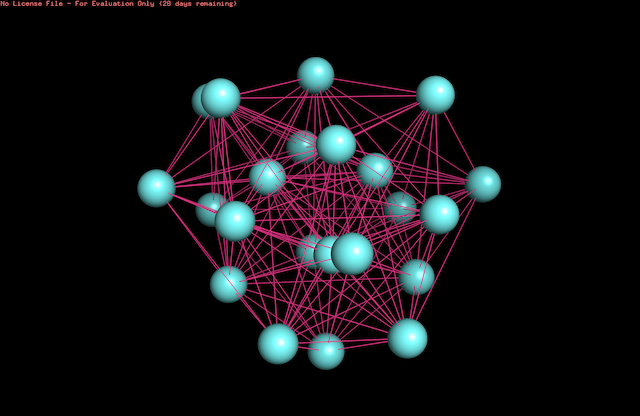

## HPC analysis

### Important Note

I continued making simulations until I could find a maximum error of about 4.5%, arriving at maximum to **N = 53**. \\
I also tried larger numbers: the error exceeded 5% and sometimes it was even lower, for example in the case of N = 60. \
However I limit the analysis up to **N = 53** for a more rigorous and consistent discussion.

### Scalability Analysis

In this section, I want to show a scalability analysis of my algorithm, with the aim of demonstrating the **effectiveness** of my solver in HPC terms, thus evaluating the already mentioned **trade-off** between **accuracy** and **performance**. \\
Here I collect the **global energy minima** and the **execution time** as a function of N, comparing the values of the minima found with those known in the literature (from the paper **Global Optimization by Basin-Hopping and the Lowest Energy Structures of Lennard-Jones Clusters Containing up to 110 Atoms**) and graphically visualizing how the execution time increases as N grows. \\
**Important Note on the Collected Data:**
- 1. The results are obtained by running the algorithm **10 times** and considering the global minimum obtained, therefore the execution time clearly is influenced by  **my choice** a priori to perform 10 runs.
- 2. All executions, to maintain consistency, are performed **ALWAYS invoking 8 threads**. For clusters with small N, this is certainly NOT the optimal number, as it may cause unnecessary overhead in terms of computational efficiency; however, **for the purposes of this scalability analysis**, I decide to consider it negligible but still want to highlight it.

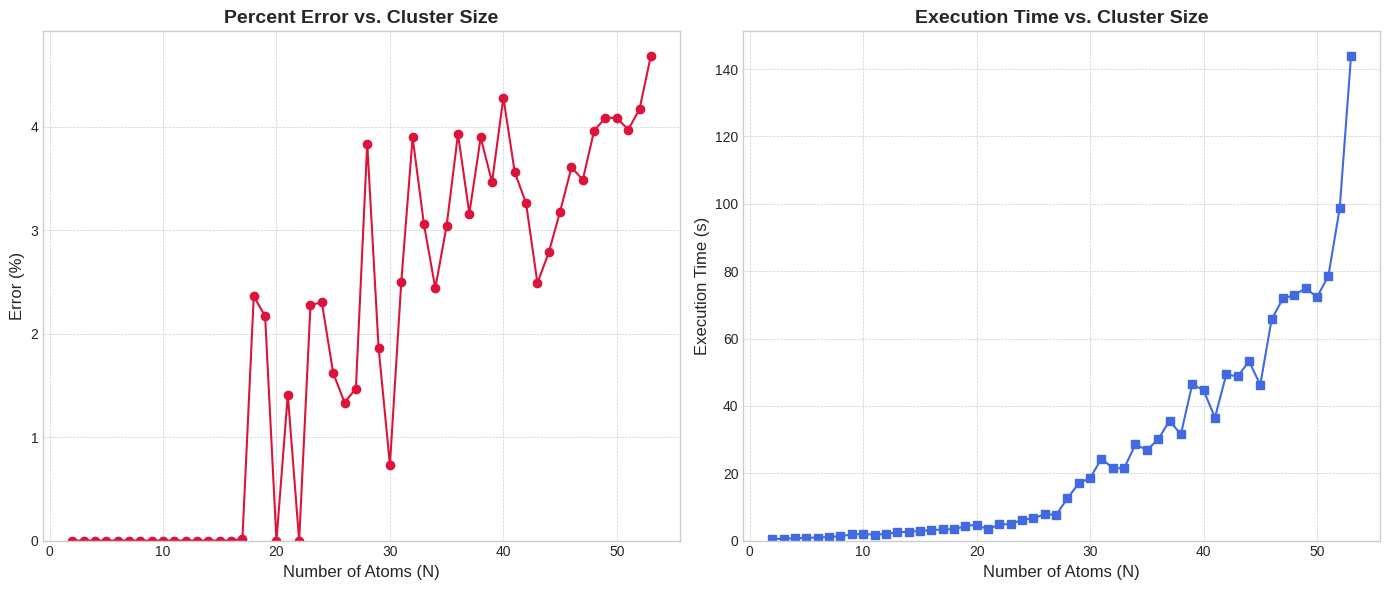

Graphs successfully saved to file 'Scalability_Analysis.png'


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ==============================================================================
# 1. REFERENCE AND EXPERIMENTAL DATA
# ==============================================================================

benchmark_energies = {
    2: -1.00000,
    3: -3.00000,
    4: -6.00000,
    5: -9.10385,
    6: -12.7121,
    7: -16.5054,
    8: -19.8215,
    9: -24.1134,
    10: -28.4225,
    11: -32.766,
    12: -37.96760,
    13: -44.32680,
    14: -47.8452,
    15: -52.3226,
    16: -56.8157,
    17: -61.317995,
    18: -66.530949,
    19: -72.659782,
    20: -77.1770,
    21: -81.684571,
    22: -86.8098,
    23: -92.844472,
    24: -97.348815,
    25: -102.372663,
    26: -108.315616,
    27: -112.873584,
    28: -117.822402,
    29: -123.587371,
    30: -128.286571,
    31: -133.586422,
    32: -139.635524,
    33: -144.842719,
    34: -150.044528,
    35: -155.756643,
    36: -161.825363,
    37: -167.033672,
    38: -173.928427,
    39: -180.033185,
    40: -185.249839,
    41: -190.536277,
    42: -196.277534,
    43: -202.364664,
    44: -207.688728,
    45: -213.784862,
    46: -220.680330,
    47: -226.012256,
    48: -232.199529,
    49: -239.091864,
    50: -244.549926,
    51: -251.253964,
    52: -258.229991,
    53: -265.203016,

}

my_results_energies = {

    2: -1.00000,
    3: -3.00000,
    4: -6.00000,
    5: -9.10385,
    6: -12.7121,
    7: -16.5054,
    8: -19.8215,
    9: -24.1134,
    10: -28.4225,
    11: -32.766,
    12: -37.967600,
    13: -44.32680,
    14: -47.8452,
    15: -52.3226,
    16: -56.8157,
    17: -61.3071,
    18: -64.9601,
    19: -71.0827,
    20: -77.1770,
    21: -80.5325,
    22: -86.8098,
    23: -90.7297,
    24: -95.1075,
    25: -100.714,
    26: -106.87,
    27: -111.216,
    28: -113.301,
    29: -121.281,
    30: -127.346,
    31: -130.251,
    32: -134.193,
    33: -140.416,
    34: -146.383,
    35: -151.014,
    36: -155.465,
    37: -161.754,
    38: -167.151,
    39: -173.796,
    40: -177.316,
    41: -183.751,
    42: -189.878,
    43: -197.328,
    44: -201.904,
    45: -206.985,
    46: -212.721,
    47: -218.128,
    48: -222.998,
    49: -229.319,
    50: -234.555,
    51: -241.275,
    52: -247.461,
    53: -252.77,
}

execution_times = {
    2: 0.389,
    3: 0.571,
    4: 0.664,
    5: 0.816,
    6: 0.892,
    7: 1.080,
    8: 1.297,
    9: 1.844,
    10: 1.915,
    11: 1.802,
    12: 1.916,
    13: 2.509,
    14: 2.556,
    15: 2.893,
    16: 3.062,
    17: 3.330,
    18: 3.315,
    19: 4.344,
    20: 4.686,
    21: 3.303,
    22: 4.834,
    23: 4.832,
    24: 6.190,
    25: 6.560,
    26: 7.853,
    27: 7.629,
    28: 12.505,
    29: 17.024,
    30: 18.570,
    31: 24.316,
    32: 21.507,
    33: 21.454,
    34: 28.600,
    35: 26.863,
    36: 30.048,
    37: 35.607,
    38: 31.557,
    39: 46.398,
    40: 44.659,
    41: 36.525,
    42: 49.340,
    43: 48.742,
    44: 53.217,
    45: 46.303,
    46: 65.72,
    47: 71.89,
    48: 72.88,
    49: 74.94,
    50: 72.284,
    51: 78.578,
    52: 98.71,
    53: 144.02

}

# ==============================================================================
# 2. DATA PREPARATION FOR THE PLOTS
# ==============================================================================
n_values = sorted(my_results_energies.keys())
times = [execution_times[n] for n in n_values]

# Compute the percentage error for each point
errors = []
for n in n_values:
    if n in benchmark_energies:
        found_energy = my_results_energies[n]
        bench_energy = benchmark_energies[n]
        abs_error = abs(found_energy - bench_energy)
        perc_error = (abs_error / abs(bench_energy)) * 100
        errors.append(perc_error)
    else:
        errors.append(np.nan)

# ==============================================================================
# 3. PLOTS CREATION
# ==============================================================================


plt.style.use('seaborn-v0_8-whitegrid')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# --- Plot 1: Error vs. N ---
ax1.plot(n_values, errors, marker='o', linestyle='-', color='crimson')
ax1.set_title('Percent Error vs. Cluster Size', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Atoms (N)', fontsize=12)
ax1.set_ylabel('Error (%)', fontsize=12)
ax1.set_ylim(bottom=0)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# --- Plot 2: Time vs. N ---
ax2.plot(n_values, times, marker='s', linestyle='-', color='royalblue')
ax2.set_title('Execution Time vs. Cluster Size', fontsize=14, fontweight='bold')
ax2.set_xlabel('Number of Atoms (N)', fontsize=12)
ax2.set_ylabel('Execution Time (s)', fontsize=12)
ax2.set_ylim(bottom=0)
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)


plt.tight_layout()

# Save the figure as a high-quality PNG file
plt.savefig('Scalability_Analysis.png', dpi=300)

plt.show()

print("Graphs successfully saved to file 'Scalability_Analysis.png'")

**Percent Error vs Cluster Size**: This graph demonstrates both the **robustness of our solver** and confirms the **immense difficulty of the problem**. We can identify two distinct phases: \\
- 1.**The " Relatively Easy" Phase ($N <= 22$)**: The error is consistently zero (except for three clusters), indicating that for small clusters, the energy landscape is "simple enough" for the algorithm to easily find the global minimum. \\
- 2.**The Complex Phase (N > 22 up to N=53)**: The error becomes volatile, with spikes that correspond to the intrinsic difficulty of specific cluster sizes. \\

Crucially, despite this volatility, the algorithm successfully **keeps the error below the 5% threshold** across the entire range. This demonstrates that the solver effectively balances the need for computational speed with the ability to find high-quality solutions, achieving a competitive and robust result.

**Execution time vs Cluster Size**: also in this graph we can observe and confirm the complex nature of the problem under consideration. \\
The execution time follows a clear **super-linear (near-exponential) growth pattern**, which is expected due to the increasing number of generations required by the algorithm to navigate the exponentially more complex PES of larger clusters.

In summary, the algorithm inevitably follows **the intrinsic growth of the problem** I am solving, yet remaining in low execution times on the order of minutes. \\
Indeed, the ultimate **HPC goal** is to maximize resource usage while maintaining high performance.


**Important note on LJ38**: My solver manages to find a solution with only a 3.9% error, performing 10 runs in just ≈ 30 seconds. \\
This means that the algorithm is **robust** and the "**Brutal Jump**" feature allows for effective exploration of the notable and deceptive PES that characterizes this cluster.

### Performance Showdown: **My Custom C++/OpenMP Solver vs. SciPy**

After analyzing the performance and scalability of **my solver**, in this section I want to evaluate its efficiency by comparing it with the reference implementations available in the Python/SciPy library. \\
The comparison is performed on the challenging benchmark of the **Lennard-Jones cluster with 38 atoms (LJ38)** to assess the trade-off between solution quality and execution time.

**Experimental Context** \\
I executed as follows:
- 1. **Basin Hopping (HP)**: classic implementation on Scipy. The algorithm is **intrinsically serial**, so Scipy does not provide the ability to parallelize the algorithm at the thread level, although the underlying numerical libraries like BLAS used by NumPy can leverage multiple cores for some mathematical operations. A **single run** of the algorithm was performed for time reasons. \\
Here is the code used and suggested by Prof. Raos during his laboratory:

In [ ]:
# BASIN HOPPING (WALES AND DOYE).

# Attempt to find the abolute minimum for a cluster of N LJ atoms.
# We use "reduced units", so that in the LJ potential epsilon=1 and sigma=1.

# For space reason, I avoid specifying the functions that define
# the LJ potential (ULJmany) and its derivative (ULJmany_der)

N = 38               # No. of atoms
Ntry = 1             # No. of random starting points
rho0 = 0.1           # Initial density of atoms
L = (N/rho0)**(1/3)  # Atoms are placed randomly inside a cube of size L.

# define here the minimizer that will be used for the local optimizations
minimizer_kwargs = {"method":'BFGS', "jac":ULJmany_der, "tol":1.0e-5,}

Energies = []
xyzfile = "cluster_"+str(N)+"_BH.xyz"
mode = "w"
for i in range(Ntry):
    print()
    print("BASIN HOPPING. Starting geometry no.", i)
    coords = L*np.random.random_sample((N,3)) - L/2
    xyz = coords.reshape(3*N, order='C')
    %time res = opt.basinhopping(ULJmany, xyz, niter=5000, T=0.8, stepsize=0.5, \
                minimizer_kwargs=minimizer_kwargs, interval=100, disp=False)
    xyz = res.x
    energy = res.fun
    print("Attempt no.:", i, "  Energy:", energy)
    Energies.append(energy)
    coords = xyz.reshape(N, 3, order='C')
    comment = 'Optimized LJ cluster with Energy '+str(energy)
    printxyz(coords, filename=xyzfile, comment=comment, mode=mode)
    mode = "a"
Energies.sort()
print("FINAL ENERGIES FROM B.H. ON LJ CLUSTERS, N=", N)
print(Energies)



BASIN HOPPING. Starting geometry no. 0
CPU times: user 12h 49min 43s, sys: 1min 8s, total: 12h 50min 52s
Wall time: 7h 20min 36s
Attempt no.: 0   Energy: -173.92842659062836
Writing 38 atomic coordinates to file cluster_38_BH.xyz
FINAL ENERGIES FROM B.H. ON LJ CLUSTERS, N= 38
[np.float64(-173.92842659062836)]


- 2. **Differential Evolution DE (10 run)**: classical implementation on Scipy. In this case, to make the comparison as fair as possible with my implementation, I ran it locally with 8 threads, utilizing the parallel implementation provided by Scipy (I recall that DE is an algorithm naturally suited for parallelism). I tried to set up the experiment as closely as possible to the setting of my solver, both in terms of cluster initialization and hyper-parameters.

Here is the code used, taking inspiration by the code written by Prof. Raos during his laboratory:

In [ ]:
def create_initial_population(NP, N, D):
    initial_population = []
    noise_scale = 0.1

    # Compute grid dimension
    Nx = int(np.ceil(N ** (1 / 3)))

    for i in range(NP):
        atoms = []
        count = 0
        for x_i in range(Nx):
            for y_i in range(Nx):
                for z_i in range(Nx):
                    if count < N:
                        # Grid position + Gaussian noise
                        x = x_i * D + np.random.normal(0, noise_scale * D)
                        y = y_i * D + np.random.normal(0, noise_scale * D)
                        z = z_i * D + np.random.normal(0, noise_scale * D)
                        atoms.append([x, y, z])
                        count += 1
        # Flatten the coordinates and add them to the population
        initial_population.append(np.array(atoms).flatten())

    return np.array(initial_population)

In [ ]:
if __name__ == "__main__":
    N = 38
    Ntry = 10
    rho0 = 0.1
    L = (N / rho0) ** (1 / 3)
    bounds = 3 * N * [(-L / 2, +L / 2)]

    Energies = []
    xyzfile = "cluster_" + str(N) + "_DE.xyz"
    mode = "w"

    start_time = time.time()  # Start chronometer

    for i in range(Ntry):
        print()
        print(f"DIFFERENTIAL EVOLUTION (SciPy). Starting run {i + 1}/{Ntry}")


        D_cpp = 1.2   # As in my CPP implementation
        initial_pop = create_initial_population(160, N, D_cpp)    # NP = 250, as in my CPP implementation

        res = opt.differential_evolution(
            ULJmany,
            bounds=bounds,
            strategy='rand1bin',
            maxiter=10000,
            popsize=250,
            tol=0.0001,
            mutation=(0.3, 1),
            recombination=0.9,
            disp=True,
            polish=False,
            init=initial_pop,
            workers=8  # Using 8 Cores
        )

        xyz = res.x
        energy = res.fun
        print(f"  Energy: {energy}")

        Energies.append(energy)
        coords = xyz.reshape(N, 3, order='C')
        comment = 'Optimized LJ cluster with Energy ' + str(energy)
        printxyz(coords, filename=xyzfile, comment=comment, mode=mode)
        mode = "a"

    Energies.sort()
    print("\nFINAL ENERGIES FROM D.E. ON LJ CLUSTERS, N=", N)
    print(Energies)

    end_time = time.time()  # End chronometer
    duration = end_time - start_time

    print("The overall duration was: ", duration)

**Output**: FINAL ENERGIES FROM D.E. ON LJ CLUSTERS, N= 38 \\
[np.float64(-159.21432660393975), np.float64(-158.46808028069748), np.float64(-157.50337969380797), np.float64(-157.02690488770304), np.float64(-154.54108651750911), np.float64(-154.14112427214292), np.float64(-151.49090083550522), np.float64(-149.96102876774196), np.float64(-138.12989008100055), np.float64(-87.36549864008552)] \\
The overall duration was:  4731.689131975174

**Results table**

| Method | Implementation | Execution Time | Final Energy | Error (%) |
|:---|:---|:---:|:---:|:---:|
| **Basin-Hopping BH (1 run)** | Python/SciPy (1 core) | 7h 20m 36s | -173.9284 | **0.00%** |
| **Differential Evolution DE (10 run)** | Python/SciPy (8 cores) | 1h 18m 51s | -159.2143 | **8.46%** |
| **My Solver (10 run)** | **C++/OpenMP (8 cores)** | 31s | -167.151 | **3.9%** |

**Scipy BH vs my solver**: \\
- 1. **Solution quality**: Basin-Hopping proves to be the most effective algorithm in terms of quality, finding the exact global minimum (0% error) and confirming its state-of-the-art status. However, my solver achieves a highly competitive result, consistently finding a solution with a very low error margin (less than 4%).

- 2. **Computational Efficiency**: The SciPy BH implementation has a **prohibitive computational cost**, requiring over 7 hours to complete a single run. In contrast, my solver is **orders of magnitude more efficient**, completing 10 independent runs in just 31 seconds. This enormous speedup makes it a vastly more practical tool for rapid analysis and for tackling larger-scale problems.


**Scipy DE vs my solver** \\
- 1. **Computational efficiency**: both algorithms as anticipated were run in parallel on 8 cores, however my solver shows a **speedup of over 150x** ( $4731s / 31s ≈ 152x %$).

- 2. **Algorithmic advantage**: despite the much longer execution time, the same hyper-parameters, and the same cluster initialization, Scipy DE implementation gets **more than twice the error of my solver**. This highlights that the **Brutal Jump** feature indeed proves decisive and effective.


## Conclusion

This project developed and benchmarked a HPC  solver for the complex, **NP-hard problem of atomic LJ cluster optimization**.

The **primary objective** was not the search for the exact global minimum at any computational cost, but rather offers an **optimal trade-off between solution quality and execution time**.

My solver proven to be a highly competitive alternative to state-of-the-art methods.

Through a unique "stagnation and reset" mechanism (**"Brutal Jump"**) it provides an efficient **gradient-free strategy** to navigate the complex energy landscapes (**PES**).

My solver has shown itself to be both **algorithmically more effective** than the standard SciPy implementation of Differential Evolution and **orders of magnitude more efficient** than Basin-Hopping Scipy implementation, solving in minutes problems that would otherwise require hours.

### Possible Future Works

The hyper-parameter tuning, which was validated up to **N = 53**, could be extended to even larger clusters.

Furthermore, to deal with the exponentially increasing complexity, the algorithm itself could be ""**upgraded**". \\
Maybe it could be effective for example:
- 1. **Implementing a fully adaptive jDE approach**: where the **Crossover rate** **CR** is also adapted dynamically (I suppose within a small and very “high” range, such as $[0.85-0.95]$).
- 2. **Introducing a dynamic population size**: to better balance the exploration and adapting the algorithm during the different phases of the optimization search.


**Simulation of other potentials**: I want to emphasize that the algorithm created is very general. \\
In particular, it is possible to optimize the geometry of atomic clusters subjected to a potential different from the LJ by defining another objective energy function and finding the correct hyper-parameters.

## References


> [Global Optimization by Basin-Hopping and the Lowest Energy Structures of Lennard-Jones Clusters Containing up to 110 Atoms](https://pubs.acs.org/doi/10.1021/jp970984n)

> [Differential Evolution – A Simple and Efficient Heuristic for global Optimization over Continuous Spaces](https://link.springer.com/article/10.1023/A:1008202821328)



> [Self-Adapting Control Parameters in Differential Evolution: A Comparative Study on Numerical Benchmark Problems](https://www.researchgate.net/publication/3418914_Self-Adapting_Control_Parameters_in_Differential_Evolution_A_Comparative_Study_on_Numerical_Benchmark_Problems)







